## Introduction

Inflation plays a key role in shaping various aspects of the economy, from interest rates and consumer spending to investment decisions and public policy. However, predicting inflation accurately remains a significant challenge due to the complexity and unpredictability of the economic factors at play. This project aims to tackle that challenge by developing a machine learning model that can forecast the U.S. inflation rate and Consumer Price Index (CPI) for up to six months in advance. With precise and timely inflation predictions, the model will empower decision-makers, including Federal Reserve policymakers, financial analysts, corporate finance teams, government agencies, and consumers, to respond proactively to inflationary trends and make better-informed decisions on matters like interest rates, budgeting, and risk management.

The goal of the project is not just to deliver reliable short-term CPI and inflation forecasts but also to uncover valuable insights into the economic forces driving inflation. Traditional models often miss the complex, non-linear relationships between variables, which is why machine learning is an ideal approach for this task. By tapping into over 25 years of historical economic data from the Federal Reserve Economic Data (FRED) platform, covering variables such as M2 Money Supply, 10-Year Treasury Yield, and Federal Funds Rate, the project uses machine learning techniques to identify patterns that enhance forecasting accuracy.

In [272]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from collections import deque
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [244]:
data = pd.read_csv('macro_data_monthly.csv', parse_dates=['Date'], index_col='Date')

The original dataset was compiled from various Federal Reserve sources and provided in daily format. However, it was resampled to monthly frequency since most key macroeconomic indicators—such as CPI, Fed Funds Rate, GDP, Sticky Inflation, M2 Money Supply, Unemployment Rate, and Inflation—are officially published on a monthly basis.

For the 10-Year Treasury Yield, which is available daily, we selected the month-end value to maintain alignment with the rest of the dataset. This monthly resampling ensures a consistent time scale across all features, which is crucial for accurate modeling and analysis.

### Exploratory Data Analysis

In [245]:
# Display basic info
print("Data Info:")
print(data.info())
print("\nSummary Statistics:")
print(data.describe())

Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 534 entries, 1981-01-31 to 2025-06-30
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   10Y_Treasury_Yield  534 non-null    float64
 1   CPI                 534 non-null    float64
 2   Fed_Funds_Rate      534 non-null    float64
 3   GDP                 534 non-null    float64
 4   Inflation_Sticky    534 non-null    float64
 5   M2_Money_Supply     534 non-null    float64
 6   Unemployment Rate   534 non-null    float64
 7   Inflation           534 non-null    float64
dtypes: float64(8)
memory usage: 37.5 KB
None

Summary Statistics:
       10Y_Treasury_Yield         CPI  Fed_Funds_Rate           GDP  \
count          534.000000  534.000000      534.000000    534.000000   
mean             5.498258  188.120288        4.222528  12671.629736   
std              3.234940   60.868958        3.707838   7179.378796   
min              0.550000

In [246]:
data.head()

,10Y_Treasury_Yield,CPI,Fed_Funds_Rate,GDP,Inflation_Sticky,M2_Money_Supply,Unemployment Rate,Inflation
Date,,,,,,,,
1981-01-31,12.68,87.2,19.08,3124.206,12.018101,1599.8,7.5,12.35
1981-02-28,13.43,88.0,15.93,3124.206,11.229271,1609.0,7.4,11.79
1981-03-31,13.13,88.6,14.70,3124.206,10.319341,1637.5,7.4,10.61
1981-04-30,14.11,89.1,15.72,3162.532,9.710597,1657.1,7.2,10.14
1981-05-31,13.50,89.7,18.52,3162.532,9.603161,1648.4,7.5,10.14


In [247]:
# Convert Fed Funds Rate (%) to a multiplicative factor (e.g., 5% -> 1.05) for model input
data['Fed_Funds_Factor'] = (data['Fed_Funds_Rate'] / 100) + 1


In [248]:
# Convert 10-Year Treasury Yield (%) to a multiplicative factor (e.g., 4% -> 1.04) for consistency with other financial features
data['10Y_Treasury_Yield'] = (data['10Y_Treasury_Yield'] / 100) + 1


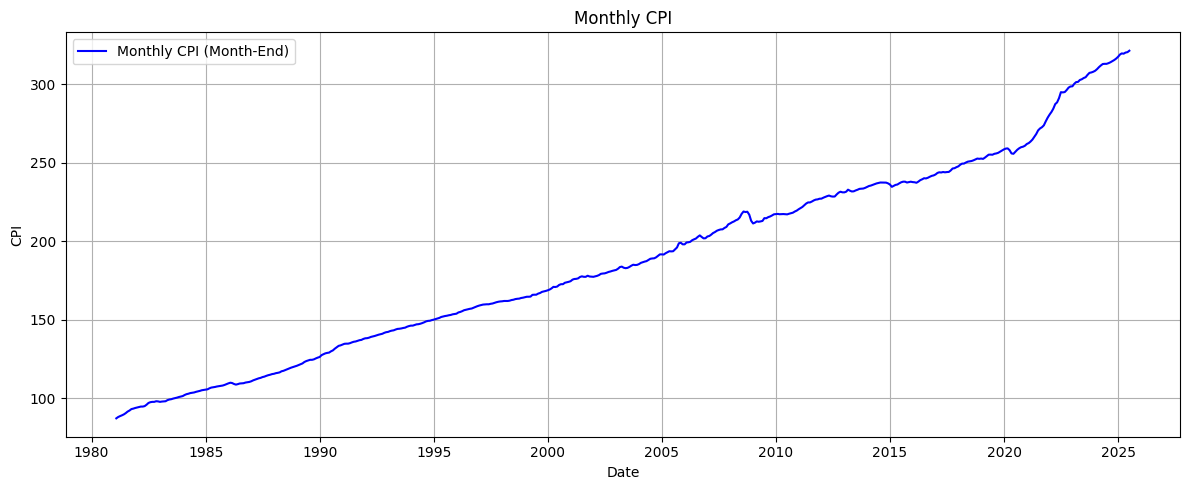

In [ ]:
# CPI data to month-end frequency
monthly_cpi = data['CPI'].resample('ME').last()

# Plot monthly CPI values
plt.figure(figsize=(12, 5))  # Set the plot size
sns.lineplot(x=monthly_cpi.index, y=monthly_cpi.values, label='Monthly CPI (Month-End)', color='blue')  # Line plot of CPI
plt.title('Monthly CPI')  
plt.xlabel('Date')  
plt.ylabel('CPI')  
plt.grid(True)  #
plt.tight_layout()  
plt.show()  


Since 2020, CPI has surged noticeably, largely due to the economic fallout from the COVID-19 pandemic. In response to the crisis, the U.S. government and Federal Reserve rolled out massive stimulus measures and slashed interest rates, injecting significant liquidity into the economy. While these actions helped stabilize demand, supply chain disruptions and labor shortages created bottlenecks, pushing prices higher. The result was a sharp and sustained increase in inflation, clearly visible in the post-2020 CPI trend.

In [250]:
# Calculate monthly rate of change (as %)
data['CPI_Rate_Change'] = data['CPI'].pct_change() * 100

# Drop the first row if needed (because of NaN from pct_change)
data = data.dropna(subset=['CPI_Rate_Change'])


C:\Users\steve\AppData\Local\Temp\ipykernel_13392\2016439849.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data.resample('M').mean()


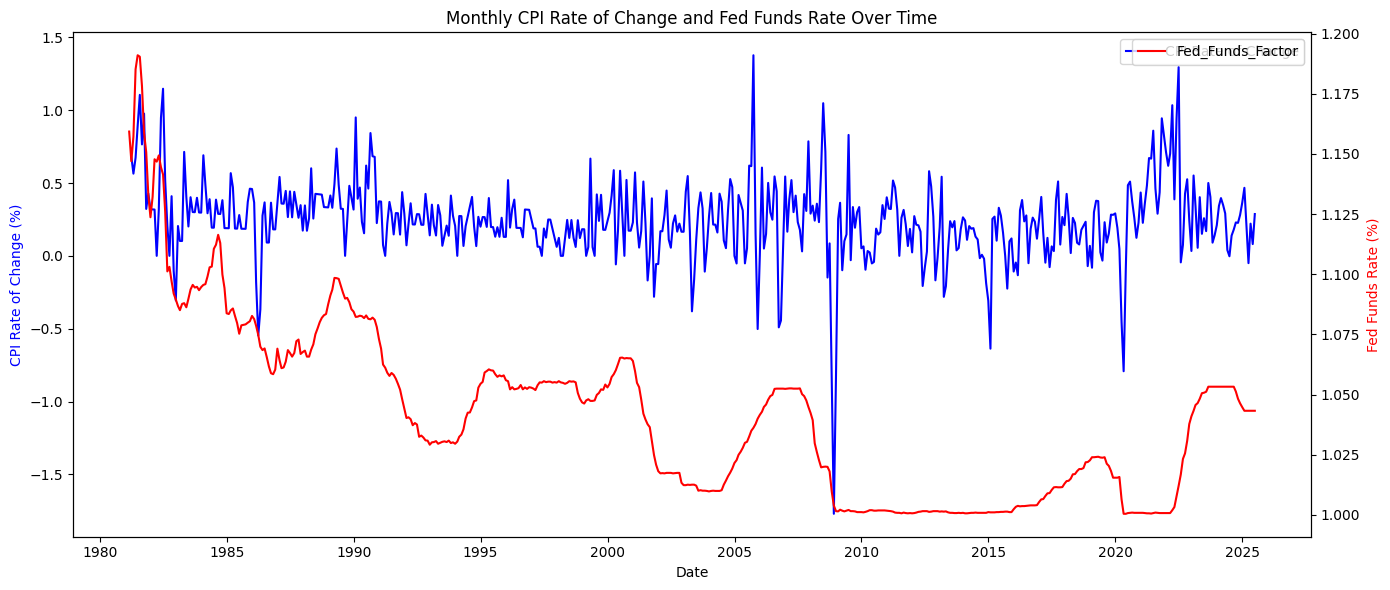

In [251]:
# Resample to monthly average
monthly_data = data.resample('M').mean()

# Calculate month-to-month CPI rate of change (%)
monthly_data['CPI_Rate_Change'] = monthly_data['CPI'].pct_change() * 100

# Create the plot
plt.figure(figsize=(14, 6))

# Plot CPI Rate of Change
ax1 = sns.lineplot(x=monthly_data.index, y=monthly_data['CPI_Rate_Change'], color='blue', label='CPI Rate of Change')
ax1.set_ylabel('CPI Rate of Change (%)', color='blue')
ax1.set_xlabel('Date')

# Plot Fed Funds Rate on secondary Y-axis
ax2 = ax1.twinx()
sns.lineplot(x=monthly_data.index, y=monthly_data['Fed_Funds_Factor'], color='red', ax=ax2, label='Fed_Funds_Factor')
ax2.set_ylabel('Fed Funds Rate (%)', color='red')

# Title and layout
plt.title('Monthly CPI Rate of Change and Fed Funds Rate Over Time')
plt.tight_layout()
plt.show()

This chart shows that changes in the Fed Funds Factor (red) tend to lag behind movements in the CPI rate of change (blue), meaning the Fed often responds to inflation after it has already started rising. For instance, after the post-2020 spike in CPI, interest rates were only raised months later. Historically, we also see that the Fed’s response to inflation, like in the 1980s and the COVID era is often gradual, likely to avoid economic shock. Overall, this suggests that interest rate policy effects on inflation are delayed, making lag variables essential for forecasting CPI accurately.

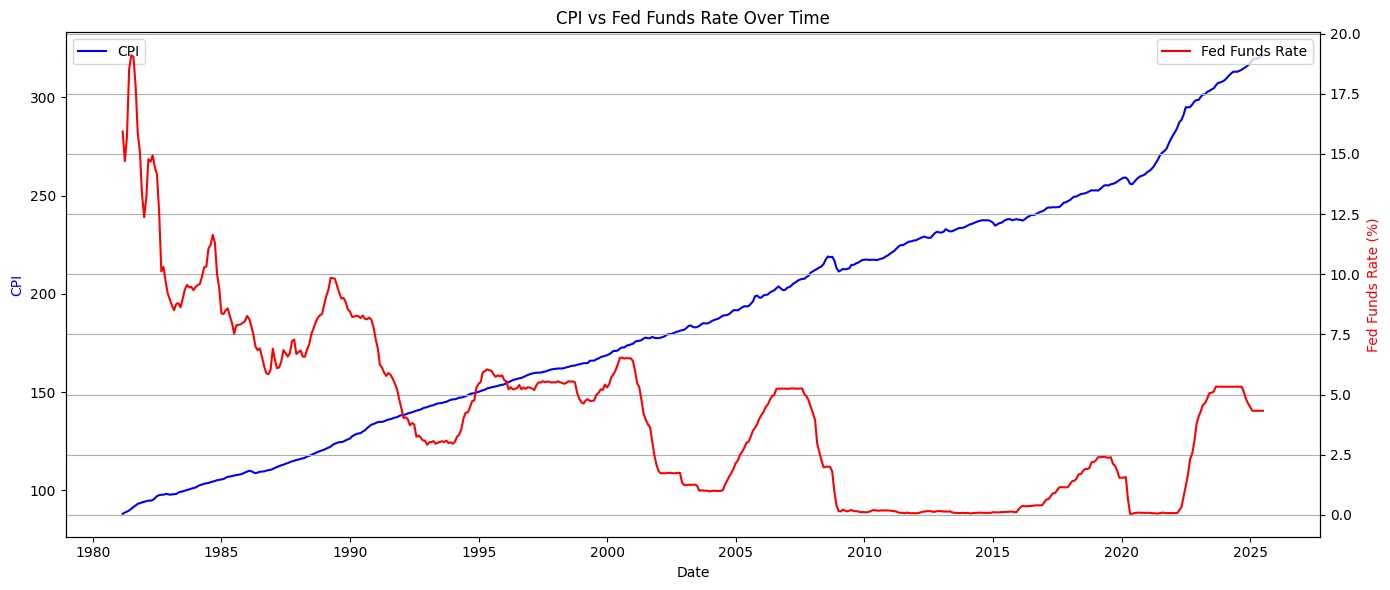

In [252]:
# Plot CPI and Fed Funds Rate
plt.figure(figsize=(14, 6))

# Plot CPI
ax1 = sns.lineplot(x=data.index, y=data['CPI'], color='blue', label='CPI')
ax1.set_ylabel('CPI', color='blue')
ax1.set_xlabel('Date')

# Plot Fed Funds Rate on secondary Y-axis
ax2 = ax1.twinx()
sns.lineplot(x=data.index, y=data['Fed_Funds_Rate'], color='red', ax=ax2, label='Fed Funds Rate')
ax2.set_ylabel('Fed Funds Rate (%)', color='red')

# Title and layout
plt.title('CPI vs Fed Funds Rate Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

This chart compares the Consumer Price Index (CPI) with the Fed Funds Rate over time, showing that while CPI (blue line) has steadily climbed for decades, the Fed Funds Rate (red line) has moved more cyclically in response to economic conditions. Notably, CPI continued rising through long periods of low interest rates, especially from 2010 to 2020, and only surged sharply after 2020. The Fed responded by rapidly raising rates, but the lag highlights how monetary policy often trails inflation trends. Overall, the graph illustrates that inflation builds gradually, while interest rate adjustments are reactive and episodic.

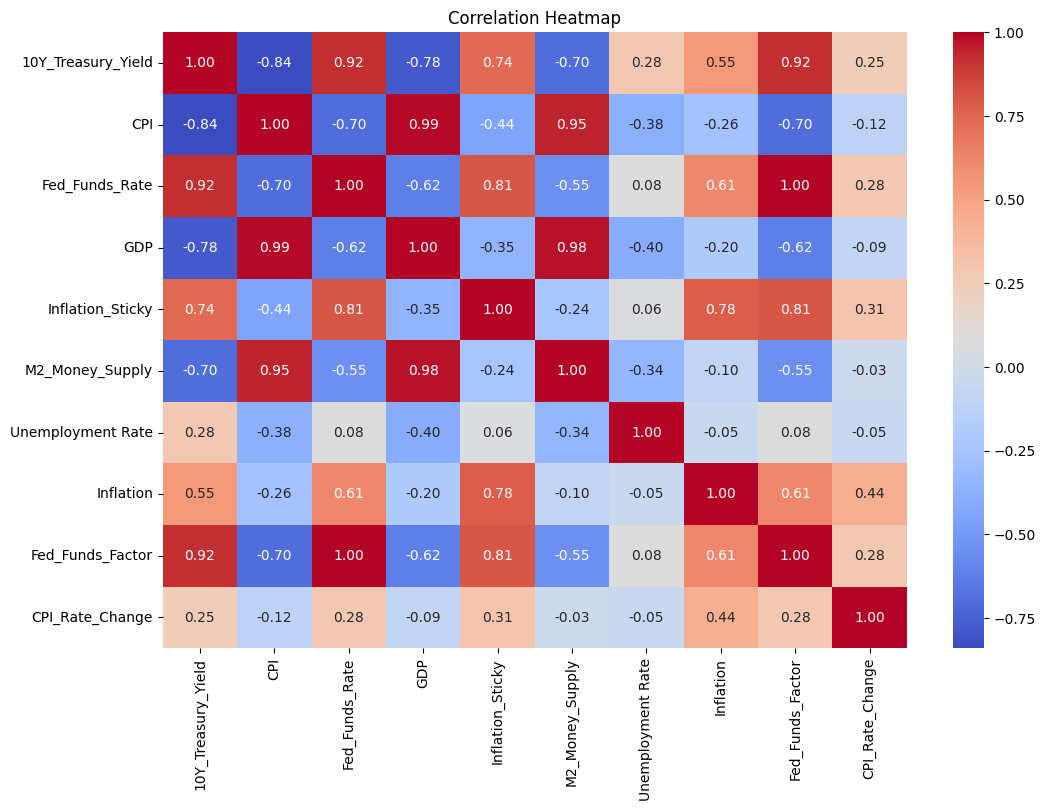

In [253]:
# Correlation heatmap (for numeric columns)
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

The heatmap reveals that CPI is strongly positively correlated with GDP (0.99) and M2 Money Supply (0.95), suggesting that as the economy grows and liquidity increases, consumer prices tend to rise. This supports the classic macroeconomic view that inflation is partly demand-driven and influenced by the volume of money circulating in the economy. CPI also has a moderately strong correlation with sticky inflation (0.78), indicating that persistent, slower-moving components of inflation tend to mirror broader price levels over time.

On the flip side, CPI shows a strong negative correlation with the 10-year Treasury Yield (-0.84) and a moderate negative correlation with both the Fed Funds Rate and its factor (-0.70). This suggests that interest rates often respond to inflation rather than drive it preemptively—highlighting the Fed’s tendency to act reactively. These inverse relationships also imply a delayed impact of rate hikes on inflation, underscoring the importance of including lagged variables when building forecasting models for CPI.

### Model Performance Evaluation

In this section, we evaluate the predictive performance of four models—**Linear Regression**, **Ridge Regression**, **Random Forest**, and **XGBoost**—across forecast horizons ranging from 1 to 12 months.

We start by calculating the annualized CPI rate of change and derive the **real interest rate** by subtracting CPI growth from the Fed Funds Rate. We then generate lag features to capture historical influence on future CPI values. For each forecast horizon, we create a target variable (CPI shifted by horizon months into the future), split the data into training and testing sets, and fit each model using the same feature set.

Each model is evaluated using **R²** and **Mean Squared Error (MSE)**. The final result is a line chart comparing R² scores across all models and forecast horizons, helping us visualize how each model's performance changes as we try to predict further into the future.


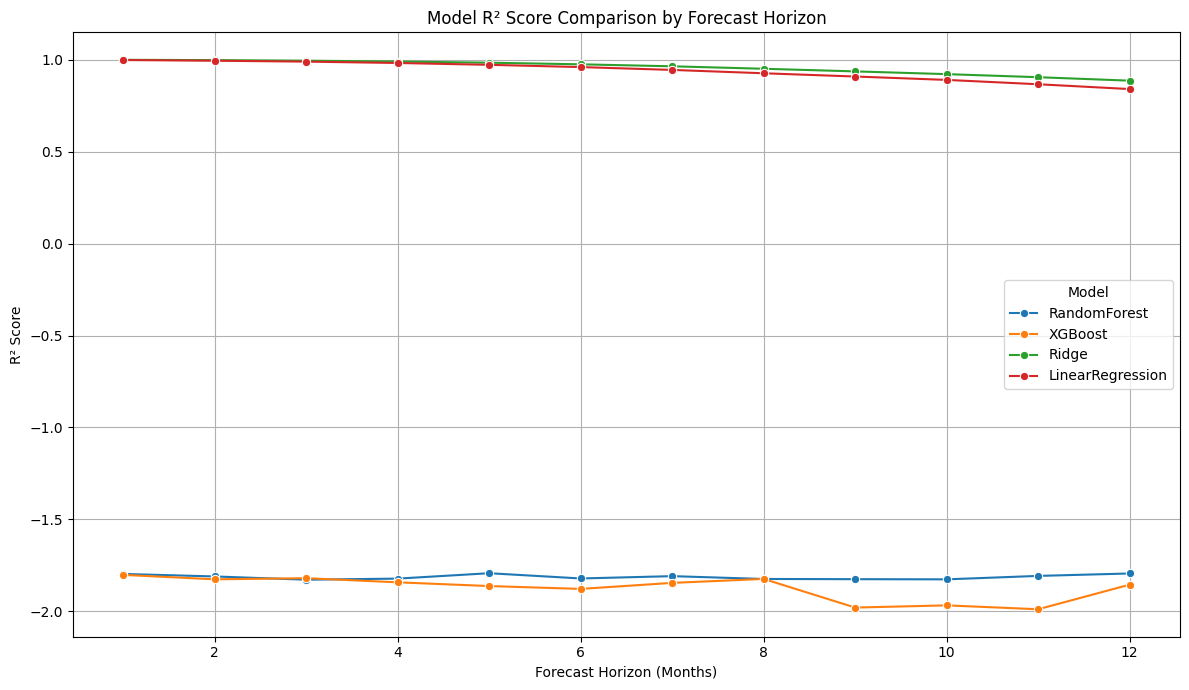

In [254]:
# Filter for rows with CPI values
data = data[data['CPI'].notna()]

# Step 1: Calculate CPI rate of change (annualized)
data['CPI_Rate'] = data['CPI'].pct_change(periods=1) * 12 * 100

# Step 2: Define Real Interest Rate
data['Real_Fed_Funds_Rate'] = data['Fed_Funds_Rate'] - data['CPI_Rate']
data['CPI_change'] = data['CPI'].pct_change(periods=1) * 100

# Step 3: Feature engineering with lags
data['CPI_lag1'] = data['CPI'].shift(1)
data['CPI_lag2'] = data['CPI'].shift(2)
data['Fed_Funds_Rate_lag1'] = data['Fed_Funds_Rate'].shift(1)
data['M2_lag1'] = data['M2_Money_Supply'].shift(1)
data['Unemployment_lag1'] = data['Unemployment Rate'].shift(1)

# Drop rows with NaNs after lagging
data = data.dropna()

# Define features used in modeling
feature_cols = [
    'CPI_lag1', 'CPI_lag2',
    'Fed_Funds_Rate_lag1',
    'M2_lag1',
    'Unemployment_lag1',
    'Real_Fed_Funds_Rate'
]

# Define models
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.05, random_state=42),
    "Ridge": make_pipeline(StandardScaler(), Ridge(alpha=1.0)),
    "LinearRegression": make_pipeline(StandardScaler(), LinearRegression())
}

# Store results
results = []

# Loop over forecast horizons
for horizon in range(1, 13):
    target_col = f'CPI_t_plus_{horizon}'
    data[target_col] = data['CPI'].shift(-horizon)

    df = data[feature_cols + [target_col]].dropna()
    X = df[feature_cols]
    y = df[target_col]

    split_idx = int(len(df) * 0.8)  
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results.append({
            "Horizon": horizon,
            "Model": model_name,
            "MSE": round(mse, 2),
            "R2": round(r2, 4)
        })

# Compile results into DataFrame
comparison_df = pd.DataFrame(results)

# Plot R² score comparison
plt.figure(figsize=(12, 7))
sns.lineplot(data=comparison_df, x="Horizon", y="R2", hue="Model", marker="o")
plt.title("Model R² Score Comparison by Forecast Horizon")
plt.ylabel("R² Score")
plt.xlabel("Forecast Horizon (Months)")
plt.grid(True)
plt.tight_layout()
plt.show()

The chart shows how well different models predict future CPI values over various forecast horizons, measured by their R² scores. LinearRegression and Ridge perform the best, maintaining high R² values close to 1.0 across all 12 months, indicating strong predictive power and stability. In contrast, RandomForest and XGBoost significantly underperform, with consistently negative R² scores, suggesting they fail to generalize and are possibly overfitting to noise. As the forecast horizon increases, the performance of all models slightly declines, which is expected due to growing uncertainty. Overall, simpler linear models like Ridge and LinearRegression appear better suited for CPI forecasting in this setup.

### Linear Regression
We will start with linear regression as it's one of the simpler models to begin with. It provides a baseline for understanding the relationship between macroeconomic indicators and CPI, and helps us interpret how each feature contributes to the prediction.

In [ ]:
# --- Ensure valid CPI data ---
data = data[data['CPI'].notna()]

# --- Create lag features to capture short- and medium-term trends ---
# These include past CPI values, lagged M2 money supply, and Fed Funds Rate lags at 1, 3, and 6 months.
# The Fed Funds Factor is transformed for compounding effect representation.

# --- Lag Feature Engineering ---
data['Fed_Funds_Factor'] = (data['Fed_Funds_Rate'] / 100) + 1
data['CPI_lag1'] = data['CPI'].shift(1)
data['M2_lag1'] = data['M2_Money_Supply'].shift(1)
data['FedFundsFactor_lag1'] = data['Fed_Funds_Factor'].shift(1)
data['FedFundsFactor_lag3'] = data['Fed_Funds_Factor'].shift(3)
data['FedFundsFactor_lag6'] = data['Fed_Funds_Factor'].shift(6)
data['CPI_1mo_ahead'] = data['CPI'].shift(-1)

# --- Feature Set with Extended Lag ---
features_1mo = [
    'Fed_Funds_Factor',
    'FedFundsFactor_lag1',
    'FedFundsFactor_lag3',
    'FedFundsFactor_lag6',
    'M2_Money_Supply',
    'M2_lag1',
    '10Y_Treasury_Yield',
    'CPI_lag1'
]

# --- Prepare Model Dataset ---
df_model = data[features_1mo + ['CPI_1mo_ahead']].dropna()
X = df_model[features_1mo]
y = df_model['CPI_1mo_ahead']

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Linear Regression Model Pipeline ---
model_1mo = make_pipeline(StandardScaler(), LinearRegression())
model_1mo.fit(X_train, y_train)

,steps,"[('standardscaler', ...), ('linearregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


In [ ]:
# -- Model Evaluation ---
y_pred = model_1mo.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"1-Month Ahead CPI Forecast - Evaluation:")
print(f"Mean Squared Error: {mse:.3f}")
print(f"R² Score: {r2:.4f}")

1-Month Ahead CPI Forecast - Evaluation:
Mean Squared Error: 1.106
R² Score: 0.9998


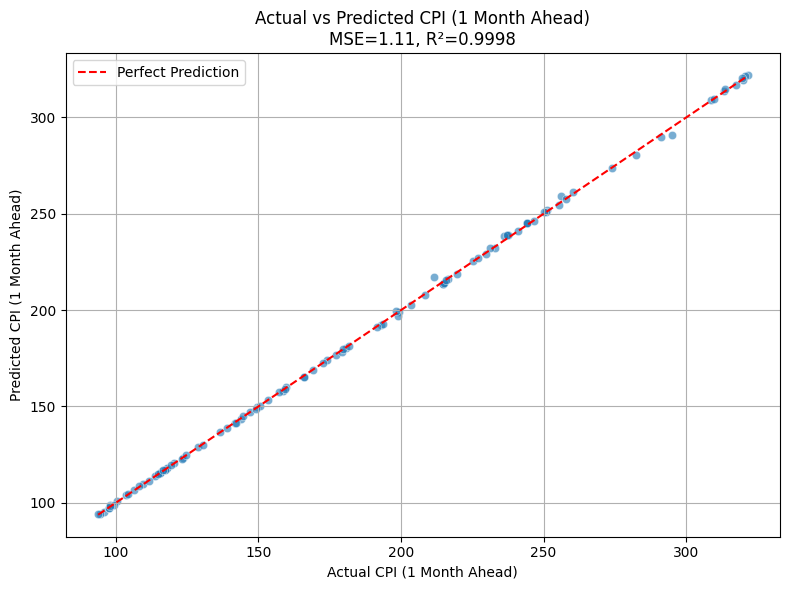

In [257]:
# --- 5. Actual vs Predicted Plot ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual CPI (1 Month Ahead)")
plt.ylabel("Predicted CPI (1 Month Ahead)")
plt.title(f"Actual vs Predicted CPI (1 Month Ahead)\nMSE={mse:.2f}, R²={r2:.4f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This plot shows how closely the model’s 1-month-ahead CPI predictions match the actual values. Most of the data points fall right along the dashed red line—which represents perfect predictions—meaning the model did an excellent job. With an R² score of 0.9998 and a tiny mean squared error of 1.11, it’s clear that the model captures short-term inflation trends almost perfectly. In other words, for predicting CPI just one month out, this model is very accurate.

C:\Users\steve\AppData\Local\Temp\ipykernel_13392\930412270.py:3: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  past_cpi = data['CPI'].dropna().last('12M')
C:\Users\steve\AppData\Local\Temp\ipykernel_13392\930412270.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  past_cpi = data['CPI'].dropna().last('12M')
C:\Users\steve\AppData\Local\Temp\ipykernel_13392\930412270.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  initial_cpi = past_cpi[-1]


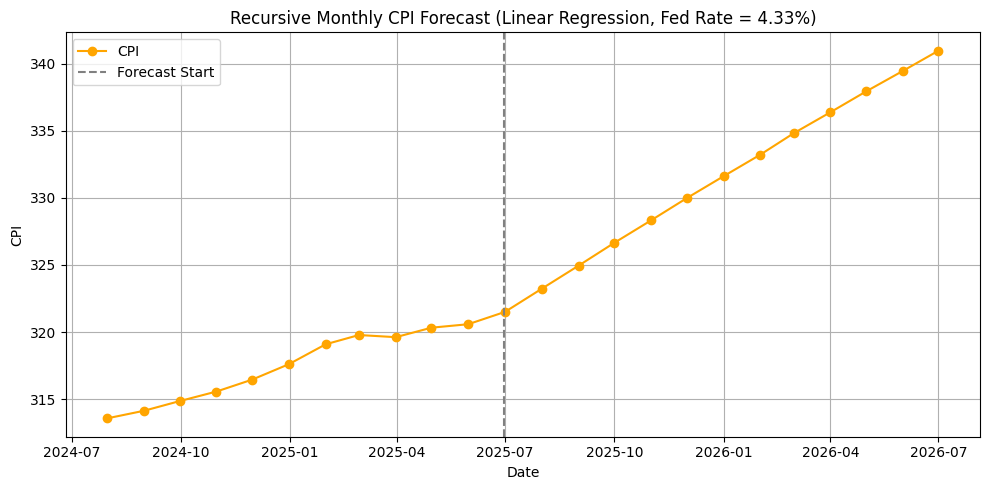


Forecast Table (Linear Regression, Fed Rate = 4.33%)
         Date  Forecasted CPI
0  2025-07-01      321.500000
1  2025-08-01      323.227834
2  2025-09-01      324.947379
3  2025-10-01      326.644618
4  2025-11-01      328.319843
5  2025-12-01      329.973337
6  2026-01-01      331.605384
7  2026-02-01      333.216260
8  2026-03-01      334.806241
9  2026-04-01      336.375598
10 2026-05-01      337.924599
11 2026-06-01      339.453507
12 2026-07-01      340.962583


In [ ]:
# --- Forecast Setup ---
last_date = data.index.max()
past_cpi = data['CPI'].dropna().last('12M')
initial_cpi = past_cpi[-1]

fed_rate = 4.33
fed_factor = (fed_rate / 100) + 1
m2 = data['M2_Money_Supply'].iloc[-1]
treasury_yield = data['10Y_Treasury_Yield'].iloc[-1]

forecast_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=13, freq='MS')  # +1 month
forecast_cpi = [initial_cpi]  # Start forecast with last historical CPI

# --- Initialize lag buffer for Fed Funds Factor ---
fed_factor_history = list(data['Fed_Funds_Factor'].dropna().iloc[-7:].values)
cpi_lag1 = initial_cpi
m2_lag1 = m2

# --- Forecast Logic (recursive for 12 future months) ---
for _ in range(12):  # previously 11
    input_df = pd.DataFrame([{
        'Fed_Funds_Factor': fed_factor_history[-1],
        'FedFundsFactor_lag1': fed_factor_history[-2],
        'FedFundsFactor_lag3': fed_factor_history[-4],
        'FedFundsFactor_lag6': fed_factor_history[-7],
        'M2_Money_Supply': m2,
        'M2_lag1': m2_lag1,
        '10Y_Treasury_Yield': treasury_yield,
        'CPI_lag1': cpi_lag1
    }])

    pred_cpi = model_1mo.predict(input_df)[0]
    forecast_cpi.append(pred_cpi)

    # update lags
    fed_factor_history.append(fed_factor)
    cpi_lag1 = pred_cpi
    m2_lag1 = m2

# --- Plotting ---
combined_dates = past_cpi.index[:-1].append(forecast_dates)
combined_cpi = past_cpi.tolist()[:-1] + forecast_cpi 

plt.figure(figsize=(10, 5))
plt.plot(combined_dates, combined_cpi, marker='o', color='orange', label='CPI')
plt.axvline(last_date, color='gray', linestyle='--', label='Forecast Start')
plt.title("Recursive Monthly CPI Forecast (Linear Regression, Fed Rate = 4.33%)")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Forecast Table ---
forecast_table = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted CPI': forecast_cpi  # includes starting CPI + 12 predicted
})
print("\nForecast Table (Linear Regression, Fed Rate = 4.33%)")
print(forecast_table)


This forecast uses a linear regression model to predict CPI over the next 12 months, starting from the most recent data point. It operates recursively, meaning each month's predicted CPI is fed into the next, along with features like the Fed Funds Rate (held constant at 4.33%), M2 money supply, and recent CPI values. The graph shows a consistently rising trend, which suggests that if current macro conditions hold steady, inflation is expected to increase in a stable fashion. However, the slope of the forecast appears steeper than historical growth, which may indicate that the model is projecting inflation momentum to persist more aggressively than what we've typically seen, possibly due to compounding effects from recursive forecasting.

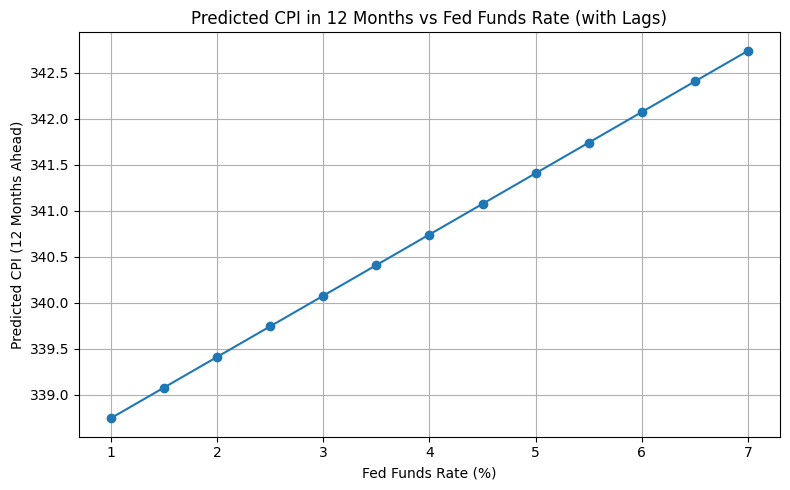


Forecast Table:
 Fed Funds Rate (%)  Predicted CPI (12 Months Ahead)
                1.0                       338.746311
                1.5                       339.079085
                2.0                       339.411858
                2.5                       339.744632
                3.0                       340.077405
                3.5                       340.410179
                4.0                       340.742952
                4.5                       341.075726
                5.0                       341.408499
                5.5                       341.741272
                6.0                       342.074046
                6.5                       342.406819
                7.0                       342.739593


In [259]:
# --- Setup for Simulation ---
rates = np.arange(1.0, 7.1, 0.5)  # Fed Funds Rate from 1.0% to 7.0%
forecast_horizon = 12  # months ahead

# Latest known values
initial_cpi = data['CPI'].dropna().iloc[-1]
m2 = data['M2_Money_Supply'].iloc[-1]
treasury_yield = data['10Y_Treasury_Yield'].iloc[-1]

# Get last 7 months of Fed_Funds_Factor history
fed_factor_history_full = list(data['Fed_Funds_Factor'].dropna().iloc[-7:].values)

# Store final CPI forecasts
predicted_cpi_12mo = []

for rate in rates:
    fed_factor = (rate / 100) + 1
    fed_factor_history = fed_factor_history_full.copy()  # fresh copy per simulation
    cpi_lag1 = initial_cpi
    m2_lag1 = m2
    forecast_cpi = []

    for _ in range(forecast_horizon):
        input_df = pd.DataFrame([{
            'Fed_Funds_Factor': fed_factor_history[-1],
            'FedFundsFactor_lag1': fed_factor_history[-2],
            'FedFundsFactor_lag3': fed_factor_history[-4],
            'FedFundsFactor_lag6': fed_factor_history[-7],
            'M2_Money_Supply': m2,
            'M2_lag1': m2_lag1,
            '10Y_Treasury_Yield': treasury_yield,
            'CPI_lag1': cpi_lag1
        }])

        pred_cpi = model_1mo.predict(input_df)[0]
        forecast_cpi.append(pred_cpi)

        # Update lags for next iteration
        fed_factor_history.append(fed_factor)
        cpi_lag1 = pred_cpi
        m2_lag1 = m2

    predicted_cpi_12mo.append(forecast_cpi[-1])

# --- Plotting ---
plt.figure(figsize=(8, 5))
plt.plot(rates, predicted_cpi_12mo, marker='o')
plt.title("Predicted CPI in 12 Months vs Fed Funds Rate (with Lags)")
plt.xlabel("Fed Funds Rate (%)")
plt.ylabel("Predicted CPI (12 Months Ahead)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Forecast Table ---
forecast_table = pd.DataFrame({
    'Fed Funds Rate (%)': rates,
    'Predicted CPI (12 Months Ahead)': predicted_cpi_12mo
})

print("\nForecast Table:")
print(forecast_table.to_string(index=False))


In this section, we used our trained model to simulate how the Consumer Price Index (CPI) might respond 12 months from now under various Fed Funds Rate scenarios, ranging from 1.0% to 7.0%. For each scenario, we kept other factors like M2 Money Supply and Treasury Yield constant, so we could isolate the impact of the interest rate. We then used a recursive forecasting approach to predict CPI month by month for a full year.

The chart shows a surprisingly steady upward trend, higher Fed rates are associated with higher predicted CPI. While that might seem odd (since rate hikes are typically used to cool inflation), it likely reflects how the model is trained on recent data where both CPI and rates were rising together. It’s a good reminder that while models can pick up patterns, they don’t always capture cause and effect—especially if the data doesn’t include enough variation or longer historical cycles.

### Ridge Regression

We’ll now try Ridge Regression, which is a linear model like standard Linear Regression but with built-in regularization. This helps prevent overfitting by penalizing overly large coefficients, especially when working with multicollinearity or many lagged features. It's a great next step to test whether adding this constraint improves stability and generalization in our CPI forecasts.

In [270]:
#To account for delayed effects of monetary policy, 
# we include lagged versions of the Fed Funds Factor at 1, 3, and 6 months. 
# This helps the model capture how past rate changes may influence CPI over time. 
# We're also using Ridge Regression with an alpha of 0.5, 
# which introduces moderate regularization to help reduce overfitting while still allowing flexibility in the model.

# Filter missing CPI values
data = data[data['CPI'].notna()]

# Feature Engineering ---
data['Fed_Funds_Factor'] = (data['Fed_Funds_Rate'] / 100) + 1
data['CPI_lag1'] = data['CPI'].shift(1)
data['M2_lag1'] = data['M2_Money_Supply'].shift(1)

# Add FedFundsFactor lag features
data['FedFundsFactor_lag1'] = data['Fed_Funds_Factor'].shift(1)
data['FedFundsFactor_lag3'] = data['Fed_Funds_Factor'].shift(3)
data['FedFundsFactor_lag6'] = data['Fed_Funds_Factor'].shift(6)

# Target variable
data['CPI_1mo_ahead'] = data['CPI'].shift(-1)

# Updated feature list
features_1mo = [
    'Fed_Funds_Factor',
    'FedFundsFactor_lag1',
    'FedFundsFactor_lag3',
    'FedFundsFactor_lag6',
    'M2_Money_Supply',
    'M2_lag1',
    '10Y_Treasury_Yield',
    'CPI_lag1'
]

# Model Preparation ---
df_model = data[features_1mo + ['CPI_1mo_ahead']].dropna()
X = df_model[features_1mo]
y = df_model['CPI_1mo_ahead']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge_model = Ridge(alpha=0.5)
ridge_model.fit(X_scaled, y_train)

# Predict normally
y_pred = ridge_model.predict(X_test_scaled)

# Model Evaluation ---
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"1-Month Ahead CPI Forecast - Evaluation:")
print(f"Mean Squared Error: {mse:.3f}")
print(f"R² Score: {r2:.4f}")

1-Month Ahead CPI Forecast - Evaluation:
Mean Squared Error: 1.264
R² Score: 0.9997


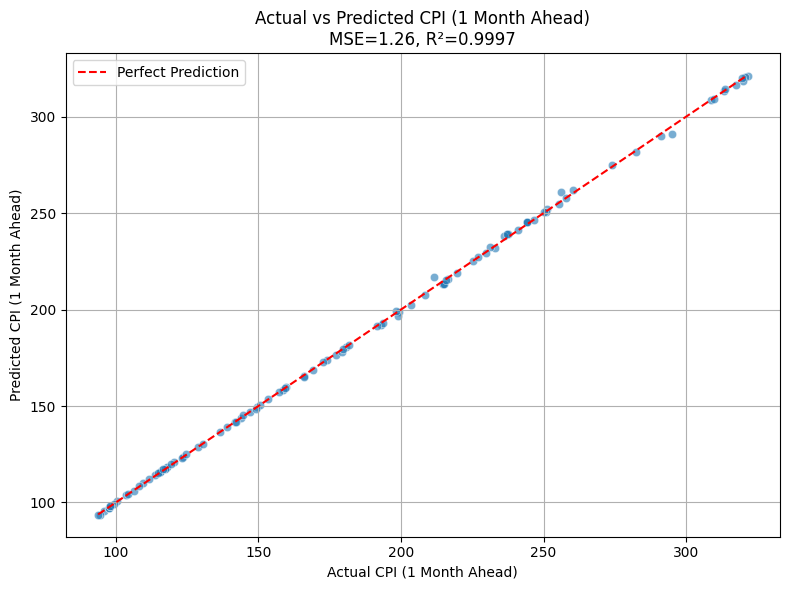

In [269]:
# Actual vs Predicted Plot ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual CPI (1 Month Ahead)")
plt.ylabel("Predicted CPI (1 Month Ahead)")
plt.title(f"Actual vs Predicted CPI (1 Month Ahead)\nMSE={mse:.2f}, R²={r2:.4f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The Ridge Regression model did an excellent job forecasting CPI one month ahead, with a very low mean squared error of 1.26 and an R² score of 0.9997, meaning it explains nearly all the variation in the actual CPI values. The scatter plot backs this up, showing that the predicted points fall almost perfectly along the line of perfect prediction. By including lagged features like the Fed Funds Rate and M2 Money Supply, and applying a bit of regularization with Ridge, the model stays accurate while avoiding overfitting. It’s a strong sign that this setup is capturing the underlying economic patterns really well.

C:\Users\steve\AppData\Local\Temp\ipykernel_13392\2717596070.py:3: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  past_cpi = data['CPI'].dropna().last('12M')
C:\Users\steve\AppData\Local\Temp\ipykernel_13392\2717596070.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  past_cpi = data['CPI'].dropna().last('12M')
C:\Users\steve\AppData\Local\Temp\ipykernel_13392\2717596070.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  initial_cpi = past_cpi[-1]


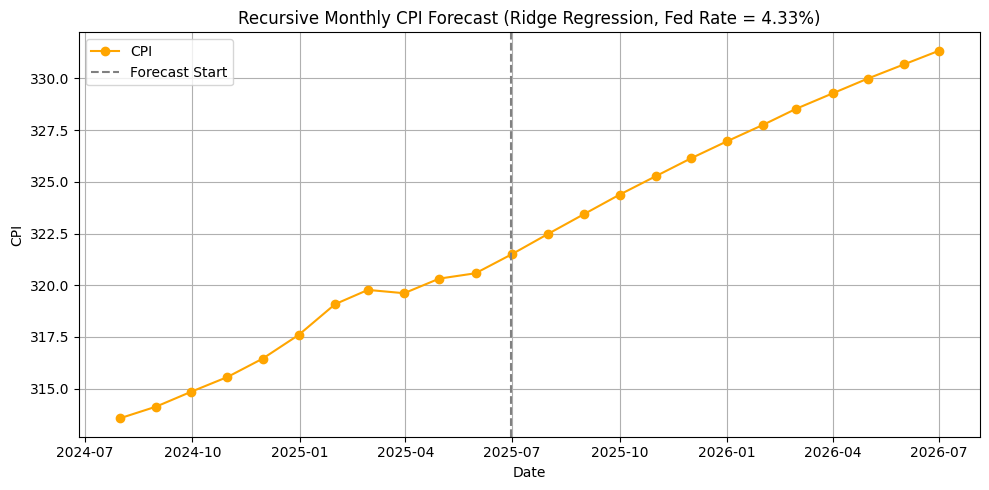


Forecast Table (Ridge Regression, Fed Rate = 4.33%)
         Date  Forecasted CPI
0  2025-07-01      321.500000
1  2025-08-01      322.484120
2  2025-09-01      323.448781
3  2025-10-01      324.377834
4  2025-11-01      325.272593
5  2025-12-01      326.134324
6  2026-01-01      326.964247
7  2026-02-01      327.763535
8  2026-03-01      328.533319
9  2026-04-01      329.274689
10 2026-05-01      329.988693
11 2026-06-01      330.676341
12 2026-07-01      331.338606


In [ ]:
# --- Corrected Recursive Forecast Setup ---
last_date = data.index.max()
past_cpi = data['CPI'].dropna().last('12M')
initial_cpi = past_cpi[-1]

fed_rate = 4.33
fed_factor = (fed_rate / 100) + 1
m2 = data['M2_Money_Supply'].iloc[-1]
treasury_yield = data['10Y_Treasury_Yield'].iloc[-1]

# Initialize history buffers
fed_factor_history = list(data['Fed_Funds_Factor'].dropna().iloc[-7:].values)
cpi_lag1 = initial_cpi
m2_lag1 = m2

forecast_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=13, freq='MS')  # Extended to 13 months
forecast_cpi = [initial_cpi]  # Start with last known value

# ---  Forecast Logic (predict 12 future months)
for _ in range(12):  
    input_df = pd.DataFrame([{
        'Fed_Funds_Factor': fed_factor_history[-1],
        'FedFundsFactor_lag1': fed_factor_history[-2],
        'FedFundsFactor_lag3': fed_factor_history[-4],
        'FedFundsFactor_lag6': fed_factor_history[-7],
        'M2_Money_Supply': m2,
        'M2_lag1': m2_lag1,
        '10Y_Treasury_Yield': treasury_yield,
        'CPI_lag1': cpi_lag1
    }])

    input_scaled = scaler.transform(input_df)
    pred_cpi = ridge_model.predict(input_scaled)[0]
    forecast_cpi.append(pred_cpi)

    # update lag trackers
    fed_factor_history.append(fed_factor)
    cpi_lag1 = pred_cpi
    m2_lag1 = m2

# --- 9. Plot Forecast ---
combined_dates = past_cpi.index[:-1].append(forecast_dates)
combined_cpi = past_cpi.tolist()[:-1] + forecast_cpi  # drop duplicated initial value from historical

plt.figure(figsize=(10, 5))
plt.plot(combined_dates, combined_cpi, marker='o', color='orange', label='CPI')
plt.axvline(last_date, color='gray', linestyle='--', label='Forecast Start')
plt.title("Recursive Monthly CPI Forecast (Ridge Regression, Fed Rate = 4.33%)")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- 10. Forecast Table ---
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted CPI': forecast_cpi
})
print("\nForecast Table (Ridge Regression, Fed Rate = 4.33%)")
print(forecast_df)


The recursive CPI forecast using Ridge Regression shows a steady upward trajectory in consumer prices over the next 12 months, assuming a constant Fed Funds Rate of 4.33%. The forecasted CPI values increase gradually from 321.50 in July 2025 to 331.34 by July 2026, suggesting continued but moderate inflationary pressure under current monetary conditions. The curve appears smoother and less steep than the forecast from linear regression, indicating that Ridge's regularization may be helping temper overly aggressive projections. Overall, the results imply a consistent inflation trend, with Ridge Regression providing a stable and reliable outlook.

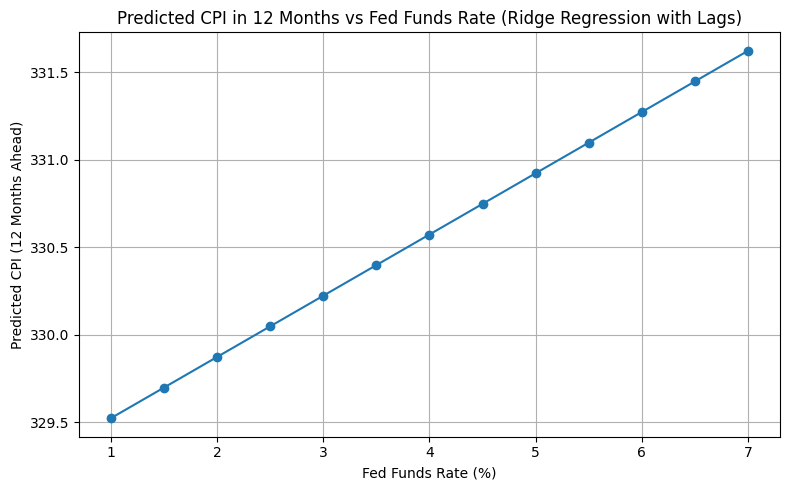

    Fed Funds Rate (%)  Predicted CPI (12 Months Ahead)
0                  1.0                       329.522724
1                  1.5                       329.697679
2                  2.0                       329.872633
3                  2.5                       330.047588
4                  3.0                       330.222542
5                  3.5                       330.397497
6                  4.0                       330.572451
7                  4.5                       330.747406
8                  5.0                       330.922360
9                  5.5                       331.097315
10                 6.0                       331.272269
11                 6.5                       331.447224
12                 7.0                       331.622178


In [262]:
# Use same model and starting CPI as your main forecast
model = ridge_model
starting_cpi = 321.5  # June 2025 CPI (last known value)

# Other macro inputs
m2 = data['M2_Money_Supply'].iloc[-1]
treasury_yield = data['10Y_Treasury_Yield'].iloc[-1]

# Define Fed rate range for simulation
rates = np.arange(1.0, 7.1, 0.5)
forecast_horizon = 12
predicted_cpi_12mo = []

# --- Run simulation for each Fed Funds Rate ---
for rate in rates:
    fed_factor = (rate / 100) + 1
    fed_factor_history = [fed_factor] * 7  # simulate history for lags
    cpi_lag1 = starting_cpi
    m2_lag1 = m2
    forecast_cpi = [starting_cpi]  # anchor to historical CPI

    for _ in range(forecast_horizon - 1):  # already added month 0
        input_df = pd.DataFrame([{
            'Fed_Funds_Factor': fed_factor_history[-1],
            'FedFundsFactor_lag1': fed_factor_history[-2],
            'FedFundsFactor_lag3': fed_factor_history[-4],
            'FedFundsFactor_lag6': fed_factor_history[-7],
            'M2_Money_Supply': m2,
            'M2_lag1': m2_lag1,
            '10Y_Treasury_Yield': treasury_yield,
            'CPI_lag1': cpi_lag1
        }])

        input_scaled = scaler.transform(input_df)
        pred_cpi = model.predict(input_scaled)[0]
        forecast_cpi.append(pred_cpi)

        # update for next month
        cpi_lag1 = pred_cpi
        m2_lag1 = m2
        fed_factor_history.append(fed_factor)

    predicted_cpi_12mo.append(forecast_cpi[-1])  # take final month's CPI

# --- Plot the corrected simulation ---
plt.figure(figsize=(8, 5))
plt.plot(rates, predicted_cpi_12mo, marker='o')
plt.title("Predicted CPI in 12 Months vs Fed Funds Rate (Ridge Regression with Lags)")
plt.xlabel("Fed Funds Rate (%)")
plt.ylabel("Predicted CPI (12 Months Ahead)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Output forecast table ---
forecast_table = pd.DataFrame({
    'Fed Funds Rate (%)': rates,
    'Predicted CPI (12 Months Ahead)': predicted_cpi_12mo
})
print(forecast_table)

The Ridge Regression simulation shows a near-linear relationship between the Fed Funds Rate and predicted CPI, with higher rates slightly increasing CPI predictions. This mild slope suggests that CPI isn’t highly sensitive to rate changes in this range, likely due to the model's inclusion of lags and inflation momentum. Compared to the linear regression model, which predicts CPI based on immediate rate changes, Ridge Regression shows a gentler response, highlighting the model’s ability to account for longer-term economic factors and lagged effects.

C:\Users\steve\AppData\Local\Temp\ipykernel_13392\1684708163.py:9: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  historical_inflation = data['Inflation'].dropna().last('12M')
C:\Users\steve\AppData\Local\Temp\ipykernel_13392\1684708163.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  historical_inflation = data['Inflation'].dropna().last('12M')


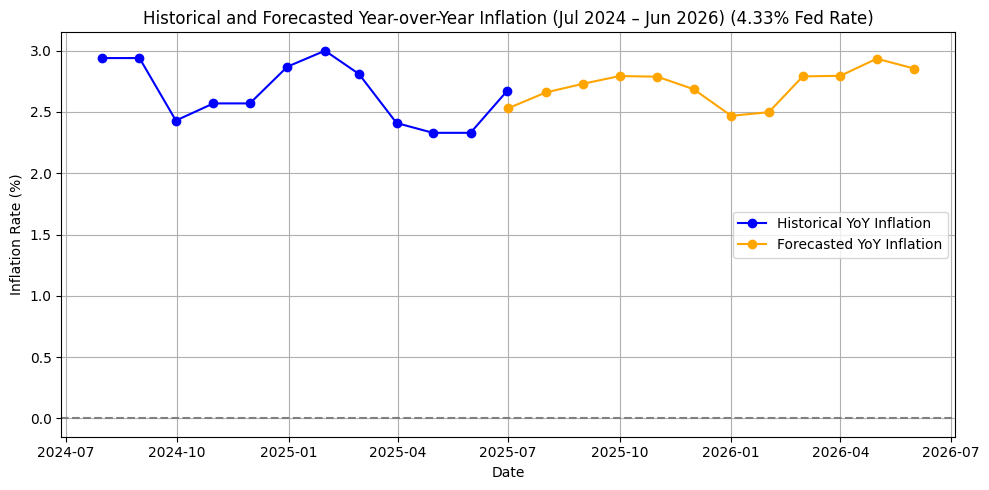

      Date  Last Year CPI  Forecasted CPI  Forecasted YoY Inflation (%)
2025-07-01        313.566      321.500000                      2.530249
2025-08-01        314.131      322.484120                      2.659120
2025-09-01        314.851      323.448781                      2.730746
2025-10-01        315.564      324.377834                      2.793042
2025-11-01        316.449      325.272593                      2.788314
2025-12-01        317.603      326.134324                      2.686160
2026-01-01        319.086      326.964247                      2.469004
2026-02-01        319.775      327.763535                      2.498174
2026-03-01        319.615      328.533319                      2.790332
2026-04-01        320.321      329.274689                      2.795224
2026-05-01        320.580      329.988693                      2.934897
2026-06-01        321.500      330.676341                      2.854227


In [271]:
# --- Inflation Calculation ---
# Year-over-year inflation is calculated by comparing the forecasted CPI with the CPI from the previous year.
# The formula used is: ((Current Year CPI - Previous Year CPI) / Previous Year CPI) * 100
# This provides the percentage change in CPI over a 12-month period, which is a standard measure of inflation.


# --- Historical Data ---
# Pull the last 12 months of actual inflation from the dataset
historical_inflation = data['Inflation'].dropna().last('12M')
historical_dates = historical_inflation.index

# --- Forecasted Data ---
last_year_cpi = [
    313.566, 314.131, 314.851, 315.564, 316.449, 317.603,
    319.086, 319.775, 319.615, 320.321, 320.580, 321.500
]

forecast_cpi = [
    321.500000, 322.484120, 323.448781, 324.377834,
    325.272593, 326.134324, 326.964247, 327.763535,
    328.533319, 329.274689, 329.988693, 330.676341
]

forecast_dates = pd.date_range(start='2025-07-01', periods=12, freq='MS')

forecasted_inflation = [
    ((fc - lc) / lc) * 100
    for fc, lc in zip(forecast_cpi, last_year_cpi)
]

# --- Combine for Plotting ---
all_dates = list(historical_dates) + list(forecast_dates)
all_inflation = historical_inflation.tolist() + forecasted_inflation

# --- Plot Historical + Forecasted Inflation ---
plt.figure(figsize=(10, 5))
plt.plot(historical_dates, historical_inflation, marker='o', label='Historical YoY Inflation', color='blue')
plt.plot(forecast_dates, forecasted_inflation, marker='o', label='Forecasted YoY Inflation', color='orange')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Historical and Forecasted Year-over-Year Inflation (Jul 2024 – Jun 2026) (4.33% Fed Rate)")
plt.xlabel("Date")
plt.ylabel("Inflation Rate (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Forecast Table ---
forecast_table = pd.DataFrame({
    'Date': forecast_dates,
    'Last Year CPI': last_year_cpi,
    'Forecasted CPI': forecast_cpi,
    'Forecasted YoY Inflation (%)': forecasted_inflation
})

# Display the forecast table
print(forecast_table.to_string(index=False))


This code compares the historical and forecasted year-over-year inflation from July 2024 to June 2026, assuming an unchanged 4.33% Fed Funds Rate. It pulls the last 12 months of actual inflation data from the dataset and calculates the forecasted CPI for the next 12 months. The year-over-year inflation is calculated by measuring the percentage change in CPI compared to the same month in the previous year. 

The plot clearly shows how the inflation trend has evolved over time, with historical data in blue and forecasted data in orange. You can see that while inflation fluctuates in the historical data, the forecast remains relatively stable with small variations. The accompanying forecast table provides the dates, last year's CPI, the forecasted CPI, and the predicted inflation for each month, giving a clear view of the inflation trajectory over the forecasted period.

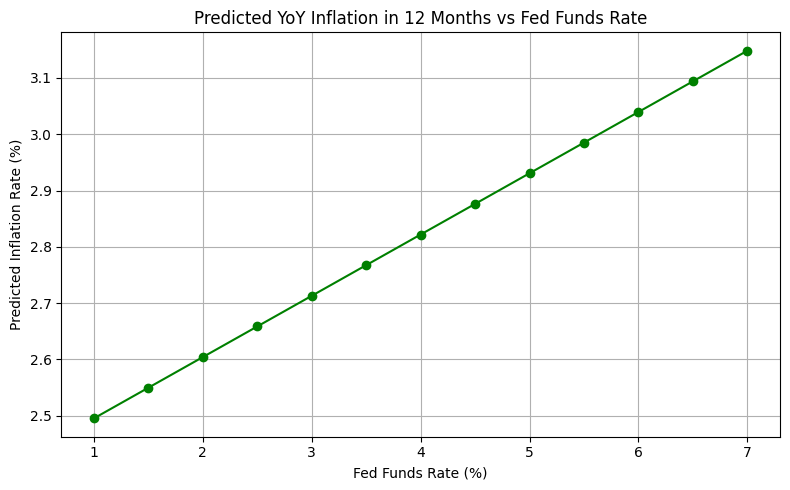

 Fed Funds Rate (%)  Predicted CPI (12 Months Ahead)  Predicted YoY Inflation (%)
                1.0                       329.522724                     2.495404
                1.5                       329.697679                     2.549822
                2.0                       329.872633                     2.604240
                2.5                       330.047588                     2.658659
                3.0                       330.222542                     2.713077
                3.5                       330.397497                     2.767495
                4.0                       330.572451                     2.821913
                4.5                       330.747406                     2.876332
                5.0                       330.922360                     2.930750
                5.5                       331.097315                     2.985168
                6.0                       331.272269                     3.039586
                

In [264]:
# --- Inputs ---
starting_cpi = 321.5  # June 2025 CPI
rates = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
predicted_cpi = [
    329.522724, 329.697679, 329.872633, 330.047588,
    330.222542, 330.397497, 330.572451, 330.747406,
    330.922360, 331.097315, 331.272269, 331.447224,
    331.622178
]

# --- Calculate YoY Inflation ---
predicted_inflation = [
    ((cpi - starting_cpi) / starting_cpi) * 100
    for cpi in predicted_cpi
]

# --- Create Forecast Table ---
forecast_df = pd.DataFrame({
    'Fed Funds Rate (%)': rates,
    'Predicted CPI (12 Months Ahead)': predicted_cpi,
    'Predicted YoY Inflation (%)': predicted_inflation
})

# --- Plot ---
plt.figure(figsize=(8, 5))
plt.plot(rates, predicted_inflation, marker='o', color='green')
plt.title("Predicted YoY Inflation in 12 Months vs Fed Funds Rate")
plt.xlabel("Fed Funds Rate (%)")
plt.ylabel("Predicted Inflation Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Display Table ---
print(forecast_df.to_string(index=False))

This analysis shows the predicted year-over-year (YoY) inflation for the next 12 months based on different Fed Funds Rates. The chart above plots the relationship between the Fed Funds Rate and the expected YoY inflation rate, with a clear positive trend. As the Fed Funds Rate increases from 1.0% to 7.0%, the predicted inflation rate also rises from 2.5% to approximately 3.15%. This suggests that as the Fed tightens monetary policy by raising interest rates, inflation is expected to increase, which is a counterintuitive result but can be explained by the lag between monetary policy adjustments and their full economic effects.

The accompanying table provides a more detailed view of the predictions. It includes the specific Fed Funds Rate used in the forecast, the predicted CPI 12 months ahead, and the corresponding YoY inflation rate for each scenario. The predicted inflation shows a steady increase with the Fed Funds Rate, indicating a strong correlation between tighter monetary policy and higher inflation expectations over the forecast period. This highlights the role of the Fed's rate changes in shaping future inflation trends.

## Summary

In this analysis, we first cleaned the CPI data and applied feature engineering with lag variables to account for delayed economic effects. We then tested multiple models, including Linear Regression and Ridge Regression, to explore how CPI forecasts responded to changes in the Fed Funds Rate over different forecast horizons. Along the way, we also analyzed predicted inflation rates and their relationship with the Fed Funds Rate.

Using the Ridge Regression model, we found that the predicted CPI over the next 12 months showed a gradual increase as the Fed Funds Rate rose, although the relationship was not steep. This result was somewhat counterintuitive since higher rates usually dampen inflation. However, the model's use of lag features and inflation momentum may help explain this pattern. Forecasted inflation ranged from about 2.5% to 3.1% over the next year, assuming the Fed Funds Rate remained at 4.33%.

Comparing Ridge Regression with Linear Regression, we found that both models predicted a similar upward trend in CPI, but Ridge Regression produced smoother predictions due to its consideration of lag effects, while Linear Regression showed a more immediate response. The inflation graphs also reflected this, with CPI and inflation moving together over time, underscoring the importance of incorporating lag variables into predictive models.

In conclusion, our findings suggest a positive relationship between the Fed Funds Rate and CPI in both models. Ridge Regression’s consideration of longer-term effects and inflation momentum provided smoother predictions, highlighting the need for lag variables to accurately capture the effects of monetary policy on inflation. The analysis reinforced that understanding delayed economic impacts is crucial for forecasting future inflation trends.